In [107]:
# COMMON
!pip install transformers
# FIRST APPROACH: It directly finds accuracy of sentiment and sarcasm detection.
# SECOND APPROACH: It removes sarcastic texts from corpus.
# THIRD APPROACH: It changes all sarcastic texts' polarity to -1 in the corpus if sarcasm exists. (1 => -1)
# FOURTH APPROACH: It changes sarcastic texts' polarity to opposite in the corpus if sarcasm exists. (-1 => 1 & 1 => -1)
# FIFTH APPROACH: It changes sarcastic texts' polarity to 1 in the corpus if sarcasm exists. (-1 => 1)

In [108]:
# COMMON
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dropout, Dense
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import metrics
import numpy as np
import tensorflow as tf

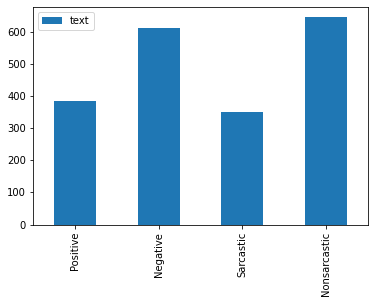

In [109]:
# COMMON
# Import data
df = pd.read_csv('text_and_annorations.csv')
df = df[['headline', 'Default_Polarity', 'is_sarcastic']]


pos = len(df[df.Default_Polarity == 1])
neg = len(df[df.Default_Polarity == -1])
sarc = len(df[df.is_sarcastic == 'Yes'])
nonsarc = len(df[df.is_sarcastic == 'No'])

# Create a sample dataframe with an text index
plotdata = pd.DataFrame(
    {"text": [pos, neg, sarc, nonsarc]}, 
    index=["Positive", "Negative", "Sarcastic", "Nonsarcastic"])
# Plot a bar chart
plotdata.plot(kind="bar")

# Remove missing rows
df = df.dropna()

df = df.groupby('Default_Polarity').filter(lambda x : len(x) > 1)
df = df.groupby('is_sarcastic').filter(lambda x : len(x) > 1)

# Convert to numeric for bert
df['Polarity'] = pd.Categorical(df['Default_Polarity'])
df['Sarcasm'] = pd.Categorical(df['is_sarcastic'])
df['Default_Polarity'] = df['Polarity'].cat.codes
df['is_sarcastic'] = df['Sarcasm'].cat.codes

In [110]:
# COMMON
# Split into training and testing 
df, df_test = train_test_split(df, test_size = 0.2, stratify = df[['Default_Polarity']])

In [111]:
# COMMON
# BERT model
modelName = 'bert-base-uncased'
maxLen = 100
conf = BertConfig.from_pretrained(modelName)
conf.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = modelName, config = conf)

# Load transformer BERT model
transformerModel = TFBertModel.from_pretrained(modelName, config = conf)

bert = transformerModel.layers[0]
inputIds = Input(shape=(maxLen,), name='input_ids', dtype='int32')
inputs = {'input_ids': inputIds}

bertModel = bert(inputs)[1]
dropout = Dropout(conf.hidden_dropout_prob, name='pooled_output')
pooledOutput = dropout(bertModel, training=False)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [112]:
# COMMON
pol = Dense(units=len(df.Default_Polarity.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='polarity')(pooledOutput)
sarc = Dense(units=len(df.is_sarcastic.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='sarcasm')(pooledOutput)
outputs = {'polarity': pol, 'sarcasm': sarc}

# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_Sentiment_Analysis')
model.summary()

Model: "BERT_For_Sentiment_Analysis"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]                       
__________________________________________________________________________________________________
polarity (Dense)                (None, 2)            1538        pooled_output[0][0]              
________________________________________________________________________

In [ ]:
# --------------------------------------------------------------FIRST APPROACH--------------------------------------------------------------------- #

In [113]:
# Training
print('FIRST APPROACH')
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'polarity': CategoricalCrossentropy(from_logits = True), 'sarcasm': CategoricalCrossentropy(from_logits = True)}
metric = {'polarity': CategoricalAccuracy('accuracy'), 'sarcasm': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.headline.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)

history = model.fit(x={'input_ids': x['input_ids']}, y={'polarity': to_categorical(df.Default_Polarity), 'sarcasm': to_categorical(df.is_sarcastic)},
                    validation_split=0.2, batch_size=64, epochs=20)



FIRST APPROACH
Epoch 1/20
10/10 [==============================] - 36s 2s/step - loss: 1.3240 - polarity_loss: 0.6726 - sarcasm_loss: 0.6514 - polarity_accuracy: 0.5896 - sarcasm_accuracy: 0.5849 - val_loss: 1.2150 - val_polarity_loss: 0.6701 - val_sarcasm_loss: 0.5449 - val_polarity_accuracy: 0.5912 - val_sarcasm_accuracy: 0.6855
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 1.1550 - polarity_loss: 0.6375 - sarcasm_loss: 0.5176 - polarity_accuracy: 0.6368 - sarcasm_accuracy: 0.7547 - val_loss: 0.9982 - val_polarity_loss: 0.6207 - val_sarcasm_loss: 0.3775 - val_polarity_accuracy: 0.6226 - val_sarcasm_accuracy: 0.8553
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 0.8143 - polarity_loss: 0.5085 - sarcasm_loss: 0.3058 - polarity_accuracy: 0.7642 - sarcasm_accuracy: 0.9009 - val_loss: 0.8295 - val_polarity_loss: 0.5416 - val_sarcasm_loss: 0.2879 - val_polarity_accuracy: 0.7233 - val_sarcasm_accuracy: 0.8805
Epoch 4/20
10/10 [=============

FIRST APPROACH


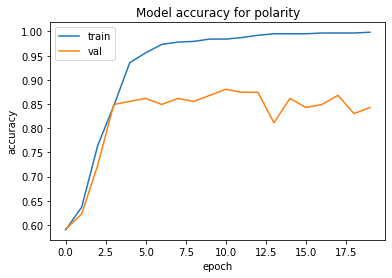

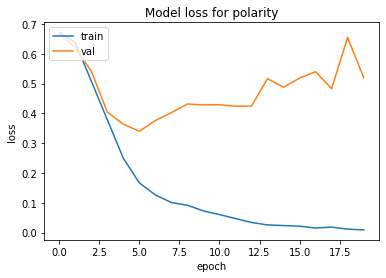



---------------------------




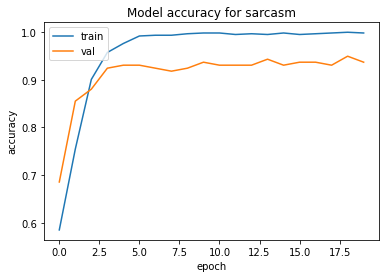

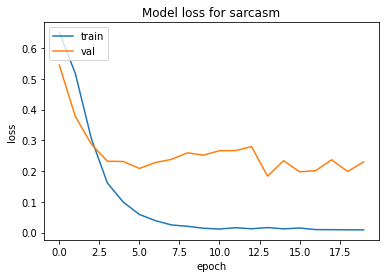

In [114]:
# Plot epochs
print('FIRST APPROACH')
plt.plot(history.history['polarity_accuracy'])
plt.plot(history.history['val_polarity_accuracy'])
plt.title('Model accuracy for polarity')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['polarity_loss'])
plt.plot(history.history['val_polarity_loss'])
plt.title('Model loss for polarity')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
print("---------------------------")
print("\n")
plt.plot(history.history['sarcasm_accuracy'])
plt.plot(history.history['val_sarcasm_accuracy'])
plt.title('Model accuracy for sarcasm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['sarcasm_loss'])
plt.plot(history.history['val_sarcasm_loss'])
plt.title('Model loss for sarcasm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
# Testing
print('FIRST APPROACH')
testPol = to_categorical(df_test.Default_Polarity)
testSarc = to_categorical(df_test.is_sarcastic)

testReview = tokenizer(text=df_test['headline'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
print(len(testPol))
print(len(testSarc))
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol, 'sarcasm': testSarc})
modelPred = model.predict({'input_ids': testReview['input_ids']})

# Evaluation
print('FOR SENTIMENT')
polarityPred =  tf.argmax(modelPred['polarity'], axis=1).numpy()
y_pred_sent = np.around(polarityPred)
print(metrics.classification_report(df_test.Default_Polarity, y_pred_sent))


print('FOR SARCASM')
sarcasmPred =  tf.argmax(modelPred['sarcasm'], axis=1).numpy()
y_pred_sarc = np.around(sarcasmPred)
print(metrics.classification_report(df_test.is_sarcastic, y_pred_sarc))

FIRST APPROACH
199
199
7/7 [==============================] - 1s 192ms/step - loss: 0.7478 - polarity_loss: 0.4187 - sarcasm_loss: 0.3291 - polarity_accuracy: 0.8894 - sarcasm_accuracy: 0.9246
FOR SENTIMENT
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       122
           1       0.85      0.87      0.86        77

    accuracy                           0.89       199
   macro avg       0.88      0.89      0.88       199
weighted avg       0.89      0.89      0.89       199

FOR SARCASM
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       126
           1       0.91      0.88      0.90        73

    accuracy                           0.92       199
   macro avg       0.92      0.91      0.92       199
weighted avg       0.92      0.92      0.92       199



In [116]:
testPol2 = df_test.Default_Polarity
testSarc = df_test.is_sarcastic

for ind in range(len(testSarc)):
  if testSarc.iloc[ind] == 1:
    testPol2.iloc[ind] = 0

testPol2Cat = to_categorical(testPol2)
testSarcCat = to_categorical(testSarc)
print('If text has sarcasm change polarity to 0 in test data:')
modelEval2 = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol2Cat})
modelPred2 = model.predict({'input_ids': testReview['input_ids']})

# Evaluation
print('FOR SENTIMENT')
polarityPred2 =  tf.argmax(modelPred2['polarity'], axis=1).numpy()
y_pred_sent2 = np.around(polarityPred2)
print(metrics.classification_report(testPol2, y_pred_sent2))


#--------------------------------------------------------------

testPol3 = df_test.Default_Polarity

for ind in range(len(testSarc)):
  if testSarc.iloc[ind] == 1:
      testPol3.iloc[ind] = 1 

testPol3Cat = to_categorical(testPol3)
print('If text has sarcasm change polarity to 1 in test data:')
modelEval3 = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol3Cat})
modelPred3 = model.predict({'input_ids': testReview['input_ids']})

# Evaluation
print('FOR SENTIMENT')
polarityPred3 =  tf.argmax(modelPred3['polarity'], axis=1).numpy()
y_pred_sent3 = np.around(polarityPred3)
print(metrics.classification_report(testPol3, y_pred_sent3))


#-------------------------------------------------------------

testPol4 = df_test.Default_Polarity
for ind in range(len(testSarc)):
  if testSarc.iloc[ind] == 1:
    if testPol4.iloc[ind] == 0:
      testPol4.iloc[ind] = 1 
    else:
       testPol4.iloc[ind] = 0 

testPol4Cat = to_categorical(testPol4)
print('If text has sarcasm change polarity to opposite in test data:')
modelEval4 = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol4Cat})
modelPred4 = model.predict({'input_ids': testReview['input_ids']})

# Evaluation
print('FOR SENTIMENT')
polarityPred4 =  tf.argmax(modelPred4['polarity'], axis=1).numpy()
y_pred_sent4 = np.around(polarityPred4)
print(metrics.classification_report(testPol4, y_pred_sent4))

#-------------------------------------------------------------
testPol5 = df_test.Default_Polarity
headline = df_test['headline']
newTestPol5 = []
newheadline = []
for ind in range(len(testSarc)):
  if testSarc.iloc[ind] == 0:
    newTestPol5.append(testPol5.iloc[ind])
    newheadline.append(headline.iloc[ind])

testReview2 = tokenizer(text=newheadline, add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)

testPol5Cat = to_categorical(newTestPol5)
print('If text has sarcasm remove from test data:')
modelEval5 = model.evaluate(x={'input_ids': testReview2['input_ids']}, y={'polarity': testPol5Cat})
modelPred5 = model.predict({'input_ids': testReview2['input_ids']})

# Evaluation
print('FOR SENTIMENT')
polarityPred5 =  tf.argmax(modelPred5['polarity'], axis=1).numpy()
y_pred_sent5 = np.around(polarityPred5)
print(metrics.classification_report(newTestPol5, y_pred_sent5))


If text has sarcasm change polarity to 0 in test data:


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


7/7 [==============================] - 4s 193ms/step - loss: 0.3590 - polarity_loss: 0.3590 - sarcasm_loss: 0.0000e+00 - polarity_accuracy: 0.8995 - sarcasm_accuracy: 0.0000e+00
FOR SENTIMENT
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       128
           1       0.82      0.92      0.87        71

    accuracy                           0.90       199
   macro avg       0.89      0.90      0.89       199
weighted avg       0.90      0.90      0.90       199

If text has sarcasm change polarity to 1 in test data:
7/7 [==============================] - 1s 197ms/step - loss: 1.7909 - polarity_loss: 1.7909 - sarcasm_loss: 0.0000e+00 - polarity_accuracy: 0.6030 - sarcasm_accuracy: 0.0000e+00
FOR SENTIMENT
              precision    recall  f1-score   support

           0       0.40      0.87      0.55        55
           1       0.91      0.50      0.65       144

    accuracy                           0.60       199
   macro avg    

In [ ]:
# --------------------------------------------------------------SECOND APPROACH--------------------------------------------------------------------- #

In [ ]:
print('SECOND APPROACH')
df = df[(df['Sarcasm'] == 'No') & (df['is_sarcastic'] == 0)]
print(df)

SECOND APPROACH
                                              headline  ...  Sarcasm
651  Eww it was so boring and its not even funny......  ...       No
868  Staff doent pay attention the are  to young no...  ...       No
697      Jon stewart could make a hyena stop laughing.  ...       No
546  This show is hokey and the characters are unre...  ...       No
839  This is a strict camp for losers, my camp play...  ...       No
..                                                 ...  ...      ...
394  I love Ortho Tri-Cyclen.  It has never given m...  ...       No
590  I keep trying to watch and enjoy the show that...  ...       No
511  To be frank i watched this show in its first a...  ...       No
421  No more heavy long periods and cramps. The bes...  ...       No
411  I am on my second week of taking this drug.  I...  ...       No

[513 rows x 5 columns]


In [ ]:
print('SECOND APPROACH')
pol = Dense(units=len(df.Default_Polarity.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='polarity')(pooledOutput)
outputs = {'polarity': pol}
# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_Sentiment_Analysis')
model.summary()

SECOND APPROACH
Model: "BERT_For_Sentiment_Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
polarity (Dense)             (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
print('SECOND APPROACH')
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'polarity': CategoricalCrossentropy(from_logits = True)}
metric = {'polarity': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.headline.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)
history = model.fit(x={'input_ids': x['input_ids']}, y={'polarity': to_categorical(df.Default_Polarity)},
                    validation_split=0.2, batch_size=64, epochs=20)

SECOND APPROACH
Epoch 1/20
7/7 [==============================] - 28s 2s/step - loss: 0.6913 - accuracy: 0.5732 - val_loss: 0.6775 - val_accuracy: 0.5437
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.6670 - accuracy: 0.5683 - val_loss: 0.6372 - val_accuracy: 0.6796
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.5655 - accuracy: 0.8122 - val_loss: 0.4754 - val_accuracy: 0.8350
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 0.3393 - accuracy: 0.9195 - val_loss: 0.4034 - val_accuracy: 0.8350
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.1488 - accuracy: 0.9585 - val_loss: 0.2601 - val_accuracy: 0.9029
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 0.0544 - accuracy: 0.9927 - val_loss: 0.3716 - val_accuracy: 0.8835
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.0385 - accuracy: 0.9902 - val_loss: 0.3001 - val_accuracy: 0.9223
Epoch 8/20
7/7 [========

SECOND APPROACH


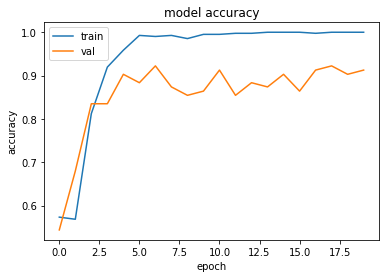

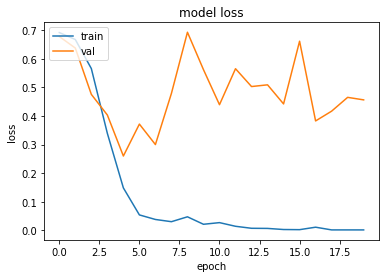

In [ ]:
# Plot epochs
print('SECOND APPROACH')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Testing
print('SECOND APPROACH')
testPol = to_categorical(df_test.Default_Polarity)
testReview = tokenizer(text=df_test['headline'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol})
modelPred = model.predict({'input_ids': testReview['input_ids']})

SECOND APPROACH
7/7 [==============================] - 1s 187ms/step - loss: 1.1778 - accuracy: 0.7688


In [ ]:
# Evaluation
print('SECOND APPROACH')
polarityPred =  tf.argmax(modelPred['polarity'], axis=1).numpy()
y_pred = np.around(polarityPred)
print(metrics.classification_report(df_test.Default_Polarity, y_pred))

SECOND APPROACH
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       122
           1       0.66      0.84      0.74        77

    accuracy                           0.77       199
   macro avg       0.77      0.78      0.77       199
weighted avg       0.79      0.77      0.77       199



In [ ]:
# --------------------------------------------------------------THIRD APPROACH--------------------------------------------------------------------- #

In [ ]:
print('THIRD APPROACH')
print(df.Polarity)
print(df.Default_Polarity)
df.loc[df.Sarcasm == 'Yes', ['Default_Polarity', 'Polarity']] = 0, -1
print(df.Default_Polarity[df.Sarcasm == 'Yes'])

THIRD APPROACH
354    1
417    1
614    1
128   -1
92    -1
      ..
860    1
886    1
930    1
86    -1
341   -1
Name: Polarity, Length: 795, dtype: category
Categories (2, int64): [-1, 1]
354    1
417    1
614    1
128    0
92     0
      ..
860    1
886    1
930    1
86     0
341    0
Name: Default_Polarity, Length: 795, dtype: int8
128    0
92     0
176    0
43     0
0      0
      ..
79     0
280    0
282    0
86     0
341    0
Name: Default_Polarity, Length: 285, dtype: int8


In [ ]:
print('THIRD APPROACH')
pol = Dense(units=len(df.Default_Polarity.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='polarity')(pooledOutput)
outputs = {'polarity': pol}
# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_Sentiment_Analysis')
model.summary()

THIRD APPROACH
Model: "BERT_For_Sentiment_Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
polarity (Dense)             (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
print('THIRD APPROACH')
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'polarity': CategoricalCrossentropy(from_logits = True)}
metric = {'polarity': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.headline.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)
history = model.fit(x={'input_ids': x['input_ids']}, y={'polarity': to_categorical(df.Default_Polarity)},
                    validation_split=0.2, batch_size=64, epochs=20)

THIRD APPROACH
Epoch 1/20
10/10 [==============================] - 33s 2s/step - loss: 0.6616 - accuracy: 0.6101 - val_loss: 0.6089 - val_accuracy: 0.6604
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.5504 - accuracy: 0.6997 - val_loss: 0.3772 - val_accuracy: 0.8491
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.2428 - accuracy: 0.9151 - val_loss: 0.2902 - val_accuracy: 0.8931
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.0960 - accuracy: 0.9748 - val_loss: 0.3505 - val_accuracy: 0.8868
Epoch 5/20
10/10 [==============================] - 14s 1s/step - loss: 0.0363 - accuracy: 0.9906 - val_loss: 0.4220 - val_accuracy: 0.8742
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.4042 - val_accuracy: 0.8931
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.3604 - val_accuracy: 0.9119
Epoch

THIRD APPROACH


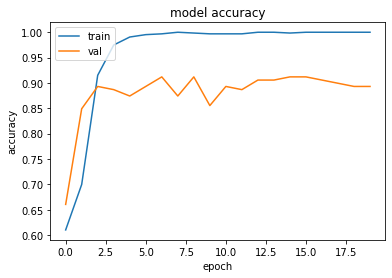

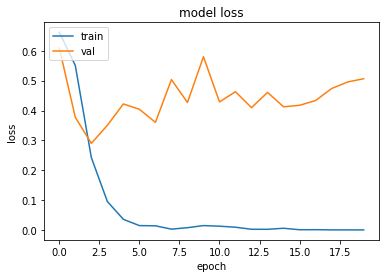

In [ ]:
# Plot epochs
print('THIRD APPROACH')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Testing
print('THIRD APPROACH')
testPol = to_categorical(df_test.Default_Polarity)
testReview = tokenizer(text=df_test['headline'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol})
modelPred = model.predict({'input_ids': testReview['input_ids']})

THIRD APPROACH
7/7 [==============================] - 1s 187ms/step - loss: 0.6396 - accuracy: 0.8945


In [ ]:
# Evaluation
print('THIRD APPROACH')
polarityPred =  tf.argmax(modelPred['polarity'], axis=1).numpy()
y_pred = np.around(polarityPred)
print(metrics.classification_report(df_test.Default_Polarity, y_pred))

THIRD APPROACH
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       122
           1       0.87      0.86      0.86        77

    accuracy                           0.89       199
   macro avg       0.89      0.89      0.89       199
weighted avg       0.89      0.89      0.89       199



In [ ]:
# --------------------------------------------------------------FOURTH APPROACH--------------------------------------------------------------------- #

In [ ]:
print('FOURTH APPROACH')
print(df.Polarity)
print(df.Default_Polarity)
df.loc[(df.Sarcasm == 'Yes') & (df.Default_Polarity == 1), 'Default_Polarity'] = 0
df.loc[(df.Sarcasm == 'Yes') & (df.Default_Polarity == 0), 'Default_Polarity'] = 1
df.loc[(df.Sarcasm == 'Yes') & (df.Polarity == -1), 'Polarity'] = 1
df.loc[(df.Sarcasm == 'Yes') & (df.Polarity == 1), 'Polarity'] = -1
print(df.Default_Polarity)

FOURTH APPROACH
72    -1
842    1
430    1
826   -1
258    1
      ..
602   -1
250   -1
923    1
579    1
64    -1
Name: Polarity, Length: 795, dtype: category
Categories (2, int64): [-1, 1]
72     0
842    1
430    1
826    0
258    1
      ..
602    0
250    0
923    1
579    1
64     0
Name: Default_Polarity, Length: 795, dtype: int8
72     1
842    1
430    1
826    0
258    1
      ..
602    0
250    1
923    1
579    1
64     1
Name: Default_Polarity, Length: 795, dtype: int8


In [ ]:
print('FOURTH APPROACH')
pol = Dense(units=len(df.Default_Polarity.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='polarity')(pooledOutput)
outputs = {'polarity': pol}
# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_Sentiment_Analysis')
model.summary()

FOURTH APPROACH
Model: "BERT_For_Sentiment_Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
polarity (Dense)             (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
print('FOURTH APPROACH')
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'polarity': CategoricalCrossentropy(from_logits = True)}
metric = {'polarity': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.headline.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)
history = model.fit(x={'input_ids': x['input_ids']}, y={'polarity': to_categorical(df.Default_Polarity)},
                    validation_split=0.2, batch_size=64, epochs=20)

FOURTH APPROACH
Epoch 1/20
10/10 [==============================] - 33s 2s/step - loss: 0.5980 - accuracy: 0.6871 - val_loss: 0.5666 - val_accuracy: 0.6981
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.4990 - accuracy: 0.7563 - val_loss: 0.4177 - val_accuracy: 0.8302
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 0.3167 - accuracy: 0.8821 - val_loss: 0.4109 - val_accuracy: 0.8239
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.2242 - accuracy: 0.9057 - val_loss: 0.3371 - val_accuracy: 0.8553
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.1127 - accuracy: 0.9654 - val_loss: 0.4031 - val_accuracy: 0.8365
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.0414 - accuracy: 0.9906 - val_loss: 0.5390 - val_accuracy: 0.8553
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.4993 - val_accuracy: 0.8805
Epoc

FOURTH APPROACH


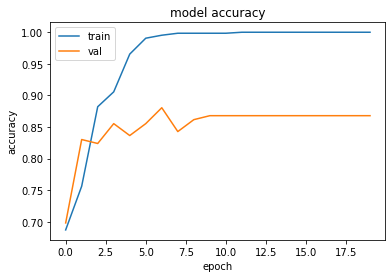

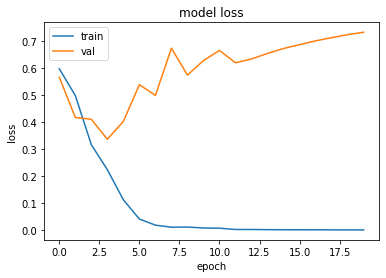

In [ ]:
# Plot epochs
print('FOURTH APPROACH')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Testing
print('FOURTH APPROACH')
testPol = to_categorical(df_test.Default_Polarity)
testReview = tokenizer(text=df_test['headline'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol})
modelPred = model.predict({'input_ids': testReview['input_ids']})

FOURTH APPROACH
7/7 [==============================] - 1s 189ms/step - loss: 2.7225 - accuracy: 0.5829


In [ ]:
# Evaluation
print('FOURTH APPROACH')
polarityPred =  tf.argmax(modelPred['polarity'], axis=1).numpy()
y_pred = np.around(polarityPred)
print(metrics.classification_report(df_test.Default_Polarity, y_pred))

FOURTH APPROACH
              precision    recall  f1-score   support

           0       0.88      0.37      0.52       122
           1       0.48      0.92      0.63        77

    accuracy                           0.58       199
   macro avg       0.68      0.65      0.58       199
weighted avg       0.73      0.58      0.56       199



In [ ]:
# --------------------------------------------------------------FIFTH APPROACH--------------------------------------------------------------------- #

In [ ]:
print('FIFTH APPROACH')
print(df.Polarity)
print(df.Default_Polarity)
df.loc[df.Sarcasm == 'Yes', ['Default_Polarity', 'Polarity']] = 1, 1
print(df.Default_Polarity[df.Sarcasm == 'Yes'])

FIFTH APPROACH
370    1
864   -1
595    1
605    1
523   -1
      ..
847    1
690    1
607   -1
485    1
146   -1
Name: Polarity, Length: 795, dtype: category
Categories (2, int64): [-1, 1]
370    1
864    0
595    1
605    1
523    0
      ..
847    1
690    1
607    0
485    1
146    0
Name: Default_Polarity, Length: 795, dtype: int8
342    1
9      1
349    1
164    1
327    1
      ..
305    1
255    1
130    1
79     1
146    1
Name: Default_Polarity, Length: 280, dtype: int8


In [ ]:
print('FIFTH APPROACH')
pol = Dense(units=len(df.Default_Polarity.value_counts()), kernel_initializer=TruncatedNormal(stddev=conf.initializer_range), name='polarity')(pooledOutput)
outputs = {'polarity': pol}
# Show model
model = Model(inputs=inputs, outputs=outputs, name='BERT_For_Sentiment_Analysis')
model.summary()

FIFTH APPROACH
Model: "BERT_For_Sentiment_Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
polarity (Dense)             (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
print('FIFTH APPROACH')
optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
loss = {'polarity': CategoricalCrossentropy(from_logits = True)}
metric = {'polarity': CategoricalAccuracy('accuracy')}
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x = tokenizer(text=df.headline.to_list(), add_special_tokens=True, max_length=maxLen, 
              truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False,
              return_attention_mask = True, verbose = True)
history = model.fit(x={'input_ids': x['input_ids']}, y={'polarity': to_categorical(df.Default_Polarity)},
                    validation_split=0.2, batch_size=64, epochs=20)

FIFTH APPROACH
Epoch 1/20
10/10 [==============================] - 34s 2s/step - loss: 0.6094 - accuracy: 0.6887 - val_loss: 0.5509 - val_accuracy: 0.7421
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.5556 - accuracy: 0.7123 - val_loss: 0.4525 - val_accuracy: 0.8113
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 0.4205 - accuracy: 0.8239 - val_loss: 0.3954 - val_accuracy: 0.8302
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.2990 - accuracy: 0.8978 - val_loss: 0.4140 - val_accuracy: 0.7799
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.1494 - accuracy: 0.9575 - val_loss: 0.4085 - val_accuracy: 0.8491
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.0780 - accuracy: 0.9811 - val_loss: 0.3687 - val_accuracy: 0.8931
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.0594 - accuracy: 0.9890 - val_loss: 0.4271 - val_accuracy: 0.8868
Epoch

FIFTH APPROACH


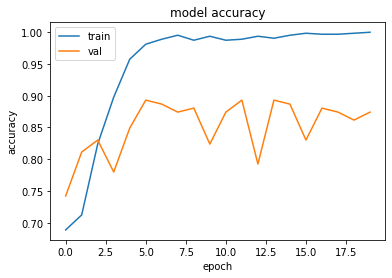

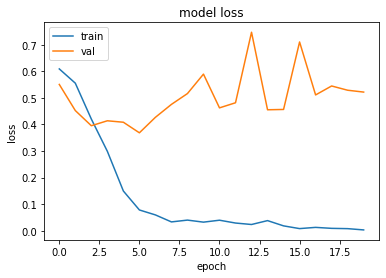

In [ ]:
# Plot epochs
print('FIFTH APPROACH')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("\n")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Testing
print('FIFTH APPROACH')
testPol = to_categorical(df_test.Default_Polarity)
testReview = tokenizer(text=df_test['headline'].to_list(), add_special_tokens=True,
                         max_length=maxLen, truncation=True, padding=True, 
                         return_tensors='tf', return_token_type_ids = False,
                         return_attention_mask = False, verbose = True)
modelEval = model.evaluate(x={'input_ids': testReview['input_ids']}, y={'polarity': testPol})
modelPred = model.predict({'input_ids': testReview['input_ids']})

FIFTH APPROACH
7/7 [==============================] - 1s 187ms/step - loss: 2.2361 - accuracy: 0.6131


In [ ]:
# Evaluation
print('FIFTH APPROACH')
polarityPred =  tf.argmax(modelPred['polarity'], axis=1).numpy()
y_pred = np.around(polarityPred)
print(metrics.classification_report(df_test.Default_Polarity, y_pred))

FIFTH APPROACH
              precision    recall  f1-score   support

           0       0.89      0.42      0.57       122
           1       0.50      0.92      0.65        77

    accuracy                           0.61       199
   macro avg       0.70      0.67      0.61       199
weighted avg       0.74      0.61      0.60       199

